# Other Samplers

Trey V. Wenger (c) June 2025

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.22.0
bayes_spec version: 1.7.9-staging+2.gb86248c.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

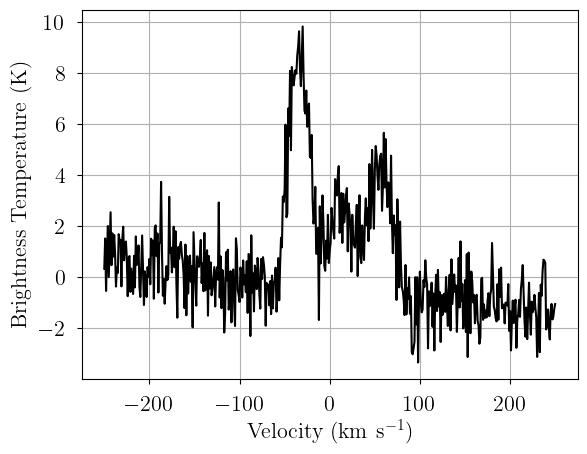

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's try the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 4,
    cores = 4,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Output()

Adding log-likelihood to trace


In [7]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [2 1 0]
Chain 2 order: [2 0 1]
Chain 3 order: [2 1 0]
Adopting (first) most common order: [2 1 0]


Sampling: [observation]


Output()

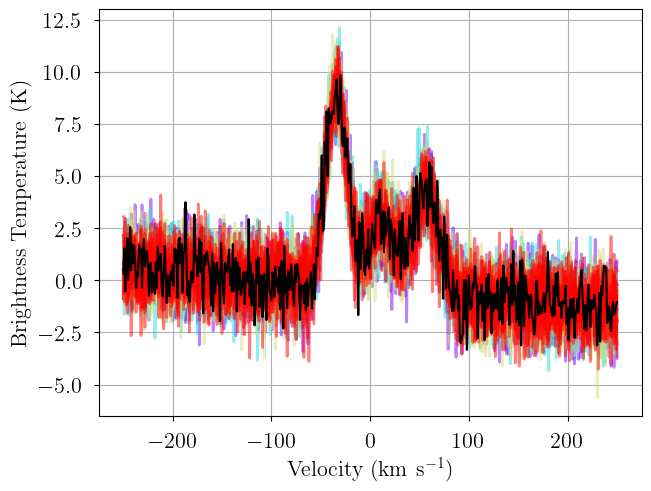

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

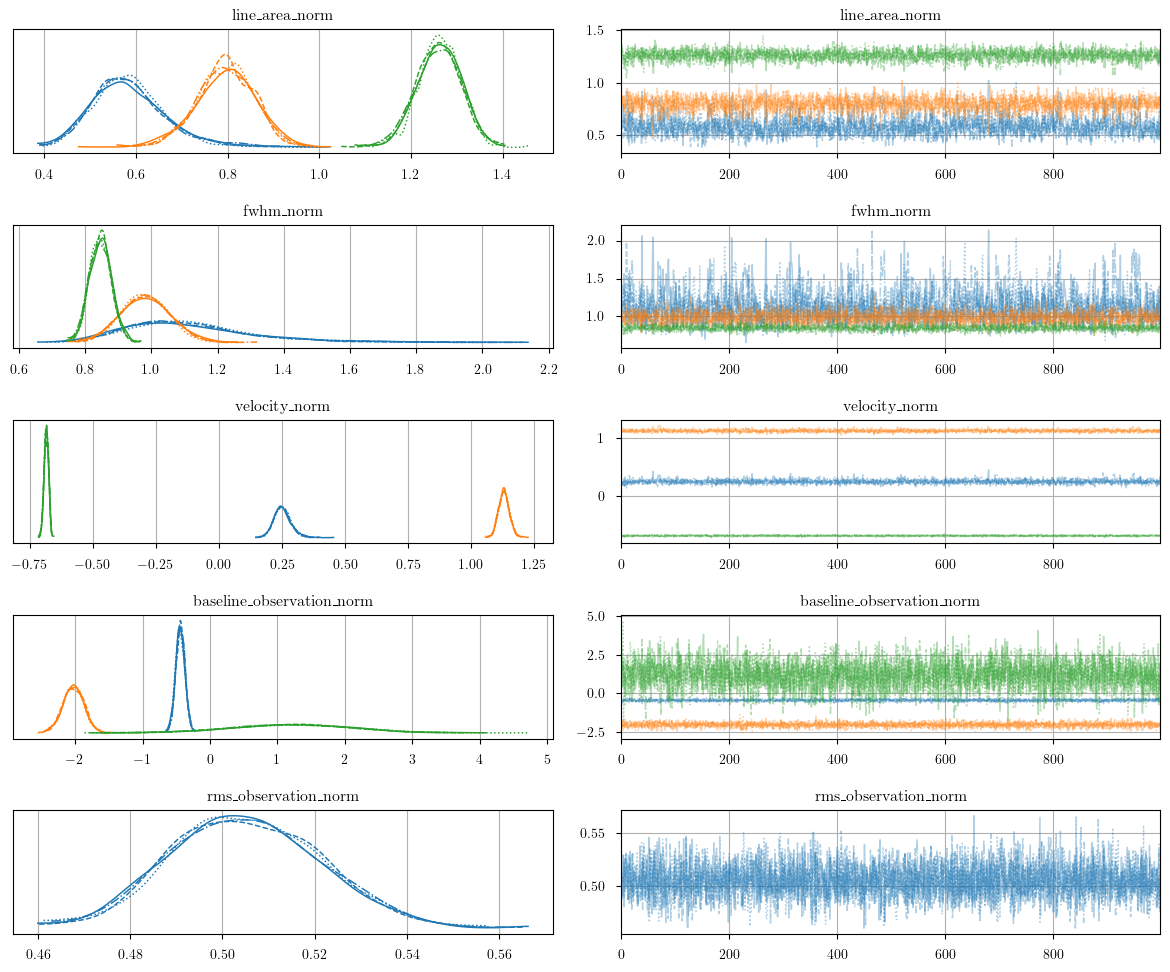

In [9]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.441   0.068   -0.566   -0.308      0.001   
baseline_observation_norm[1]   -2.027   0.152   -2.294   -1.717      0.002   
baseline_observation_norm[2]    1.214   0.873   -0.514    2.761      0.016   
velocity_norm[0]                0.253   0.034    0.194    0.321      0.001   
velocity_norm[1]                1.131   0.022    1.092    1.172      0.000   
velocity_norm[2]               -0.683   0.009   -0.699   -0.667      0.000   
line_area_norm[0]               0.585   0.081    0.434    0.730      0.002   
line_area_norm[1]               0.795   0.063    0.677    0.913      0.001   
line_area_norm[2]               1.260   0.048    1.176    1.355      0.001   
fwhm_norm[0]                    1.120   0.200    0.792    1.493      0.005   
fwhm_norm[1]                    0.982   0.074    0.853    1.133      0.002   
fwhm_norm[2]                    0.846   0.033    0.791    0.913      0.001   
rms_observation_norm            0.505   0.016    0.475    0.535      0.000   
line_area[0]                  116.937  16.181   86.815  145.985      0.408   
line_area[1]                  158.974  12.664  135.344  182.514      0.300   
line_area[2]                  252.075   9.636  235.106  270.978      0.194   
fwhm[0]                        33.598   6.015   23.773   44.794      0.157   
fwhm[1]                        29.455   2.229   25.590   33.985      0.048   
fwhm[2]                        25.393   0.980   23.715   27.383      0.019   
velocity[0]                    12.640   1.695    9.714   16.052      0.032   
velocity[1]                    56.541   1.079   54.593   58.579      0.024   
velocity[2]                   -34.166   0.442  -34.949  -33.335      0.008   
amplitude[0]                    3.301   0.290    2.754    3.852      0.005   
amplitude[1]                    5.076   0.273    4.545    5.575      0.005   
amplitude[2]                    9.330   0.286    8.776    9.856      0.004   
rms_observation                 1.010   0.032    0.951    1.070      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.001    2954.0    2388.0    1.0  
baseline_observation_norm[1]    0.002    4817.0    3064.0    1.0  
baseline_observation_norm[2]    0.013    2965.0    2633.0    1.0  
velocity_norm[0]                0.001    2975.0    2429.0    1.0  
velocity_norm[1]                0.000    2115.0    2228.0    1.0  
velocity_norm[2]                0.000    3087.0    2496.0    1.0  
line_area_norm[0]               0.002    1696.0    1570.0    1.0  
line_area_norm[1]               0.001    1844.0    1580.0    1.0  
line_area_norm[2]               0.001    2524.0    2116.0    1.0  
fwhm_norm[0]                    0.005    1674.0    1528.0    1.0  
fwhm_norm[1]                    0.001    2137.0    2259.0    1.0  
fwhm_norm[2]                    0.000    2733.0    2667.0    1.0  
rms_observation_norm            0.000    4654.0    2836.0    1.0  
line_area[0]                    0.375    1696.0    1570.0    1.0  
line_area[1]                    0.232    1844.0    1580.0    1.0  
line_area[2]                    0.158    2524.0    2116.0    1.0  
fwhm[0]                         0.152    1674.0    1528.0    1.0  
fwhm[1]                         0.033    2137.0    2259.0    1.0  
fwhm[2]                         0.014    2733.0    2667.0    1.0  
velocity[0]                     0.032    2975.0    2429.0    1.0  
velocity[1]                     0.018    2115.0    2228.0    1.0  
velocity[2]                     0.007    3087.0    2496.0    1.0  
amplitude[0]                    0.004    2814.0    3138.0    1.0  
amplitude[1]                    0.004    3572.0    3360.0    1.0  
amplitude[2]                    0.005    5522.0    3223.0    1.0  
rms_observation                 0.000    4654.0    2836.0    1.0

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference).

In [11]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

Output()

Adding log-likelihood to trace


After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [12]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 1 order: [0 1 2]
Chain 2 order: [0 2 1]
Chain 3 order: [0 2 1]
Chain 4 order: [2 1 0]
Chain 5 order: [1 2 0]
Adopting (first) most common order: [0 2 1]


Sampling: [observation]


Output()

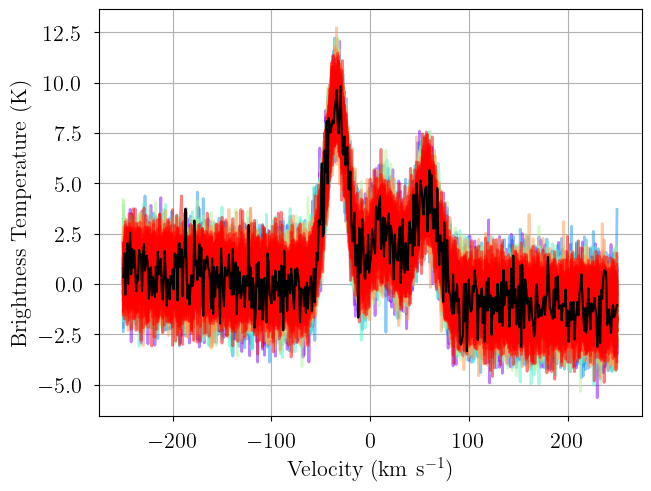

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

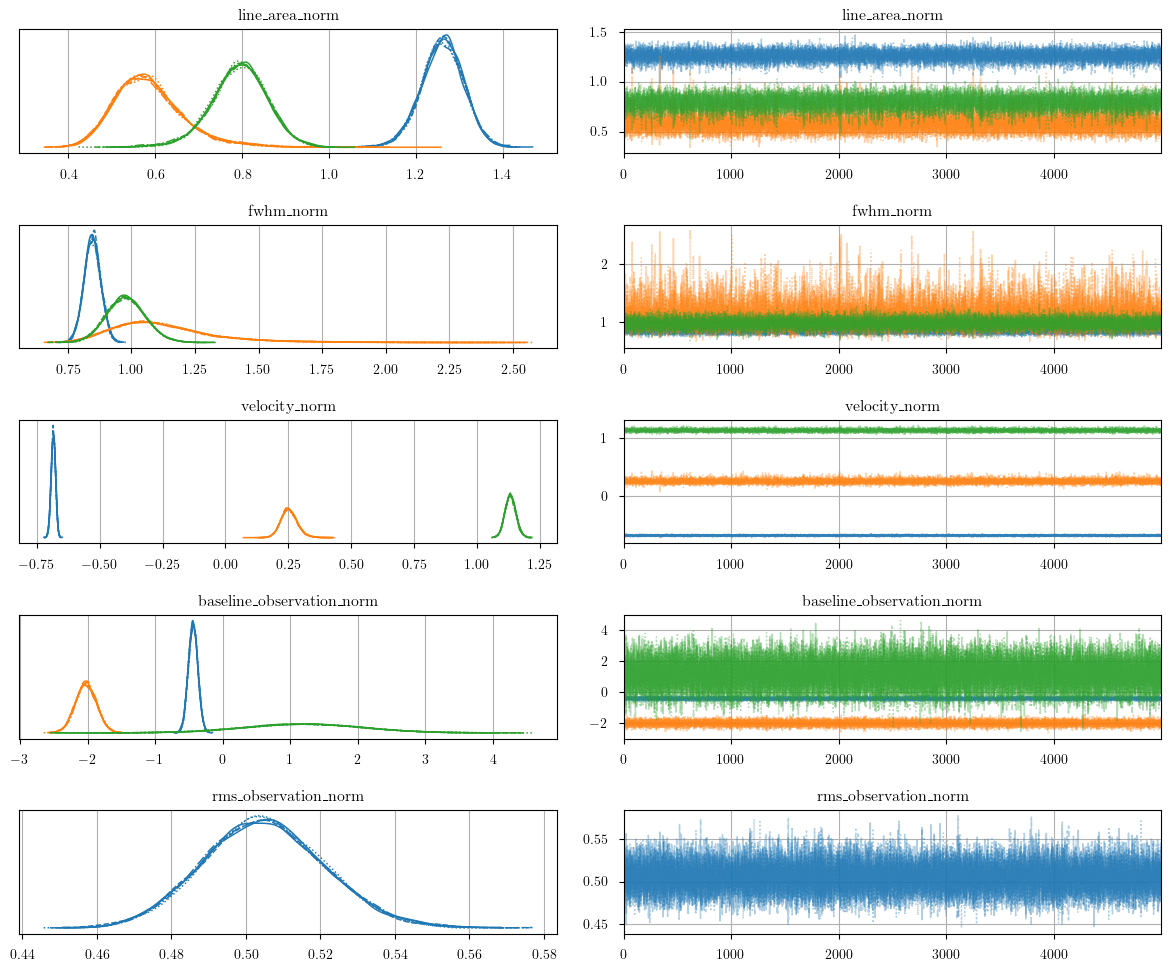

In [14]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [15]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.438   0.070   -0.569   -0.306      0.000   
baseline_observation_norm[1]   -2.025   0.156   -2.320   -1.735      0.001   
baseline_observation_norm[2]    1.188   0.871   -0.434    2.853      0.005   
line_area_norm_log__[0]         0.024   0.313   -0.605    0.315      0.125   
line_area_norm_log__[1]        -0.442   0.190   -0.746   -0.116      0.060   
line_area_norm_log__[2]        -0.133   0.291   -0.612    0.303      0.114   
fwhm_norm_log__[0]             -0.098   0.133   -0.265    0.165      0.043   
fwhm_norm_log__[1]              0.060   0.159   -0.212    0.371      0.024   
fwhm_norm_log__[2]             -0.051   0.131   -0.248    0.176      0.039   
velocity_norm[0]               -0.683   0.009   -0.700   -0.667      0.000   
velocity_norm[1]                0.253   0.034    0.190    0.316      0.000   
velocity_norm[2]                1.131   0.022    1.090    1.171      0.000   
rms_observation_norm_log__     -0.684   0.032   -0.743   -0.623      0.000   
line_area_norm[0]               1.260   0.049    1.167    1.349      0.000   
line_area_norm[1]               0.586   0.082    0.438    0.734      0.001   
line_area_norm[2]               0.792   0.065    0.672    0.918      0.001   
fwhm_norm[0]                    0.847   0.033    0.785    0.908      0.000   
fwhm_norm[1]                    1.125   0.206    0.783    1.499      0.002   
fwhm_norm[2]                    0.979   0.076    0.831    1.115      0.001   
rms_observation_norm            0.505   0.016    0.475    0.536      0.000   
line_area[0]                  251.977   9.751  233.361  269.866      0.080   
line_area[1]                  117.162  16.403   87.501  146.850      0.178   
line_area[2]                  158.425  13.020  134.338  183.514      0.132   
fwhm[0]                        25.402   0.979   23.558   27.248      0.007   
fwhm[1]                        33.742   6.176   23.502   44.974      0.070   
fwhm[2]                        29.360   2.269   24.937   33.436      0.021   
velocity[0]                   -34.168   0.438  -34.981  -33.338      0.003   
velocity[1]                    12.664   1.687    9.516   15.820      0.013   
velocity[2]                    56.566   1.081   54.476   58.546      0.010   
amplitude[0]                    9.323   0.286    8.788    9.862      0.001   
amplitude[1]                    3.295   0.292    2.759    3.857      0.002   
amplitude[2]                    5.075   0.281    4.551    5.602      0.002   
rms_observation                 1.010   0.032    0.951    1.072      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   23206.0   23015.0   1.00  
baseline_observation_norm[1]    0.001   49046.0   21140.0   1.00  
baseline_observation_norm[2]    0.004   27161.0   24841.0   1.00  
line_area_norm_log__[0]         0.070       9.0      24.0   1.73  
line_area_norm_log__[1]         0.010      12.0      91.0   1.45  
line_area_norm_log__[2]         0.049       8.0      25.0   2.16  
fwhm_norm_log__[0]              0.034      11.0      25.0   1.48  
fwhm_norm_log__[1]              0.008      49.0     536.0   1.08  
fwhm_norm_log__[2]              0.024      11.0      27.0   1.50  
velocity_norm[0]                0.000   22388.0   18708.0   1.00  
velocity_norm[1]                0.000   17982.0   15221.0   1.00  
velocity_norm[2]                0.000   12257.0   13894.0   1.00  
rms_observation_norm_log__      0.000   47781.0   22801.0   1.00  
line_area_norm[0]               0.000   15170.0   14901.0   1.00  
line_area_norm[1]               0.001    9737.0    8946.0   1.00  
line_area_norm[2]               0.001   10260.0    9505.0   1.00  
fwhm_norm[0]                    0.000   18243.0   19714.0   1.00  
fwhm_norm[1]                    0.003    9106.0    8991.0   1.00  
fwhm_norm[2]                    0.000   11937.0   14139.0   1.00  
rms_observation_norm            0.000   

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [16]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [17]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Output()

Adding log-likelihood to trace


In [18]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 1 2]
Chain 1 order: [2 1 0]
Chain 2 order: [2 0 1]
Chain 3 order: [2 0 1]
Chain 4 order: [1 2 0]
Chain 5 order: [0 1 2]
Adopting (first) most common order: [0 1 2]


Sampling: [observation]


Output()

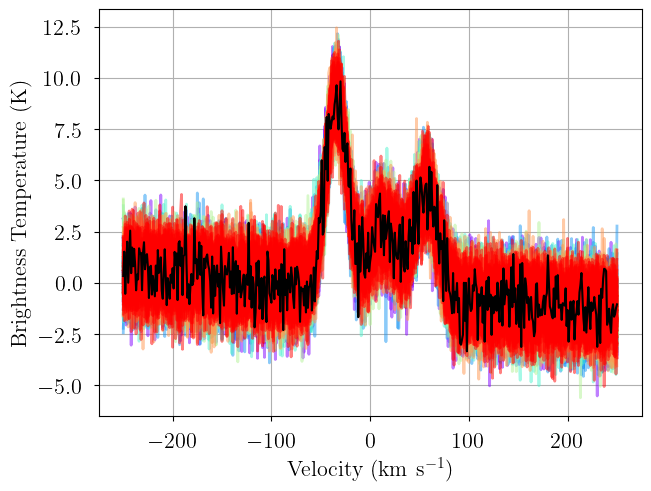

In [19]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

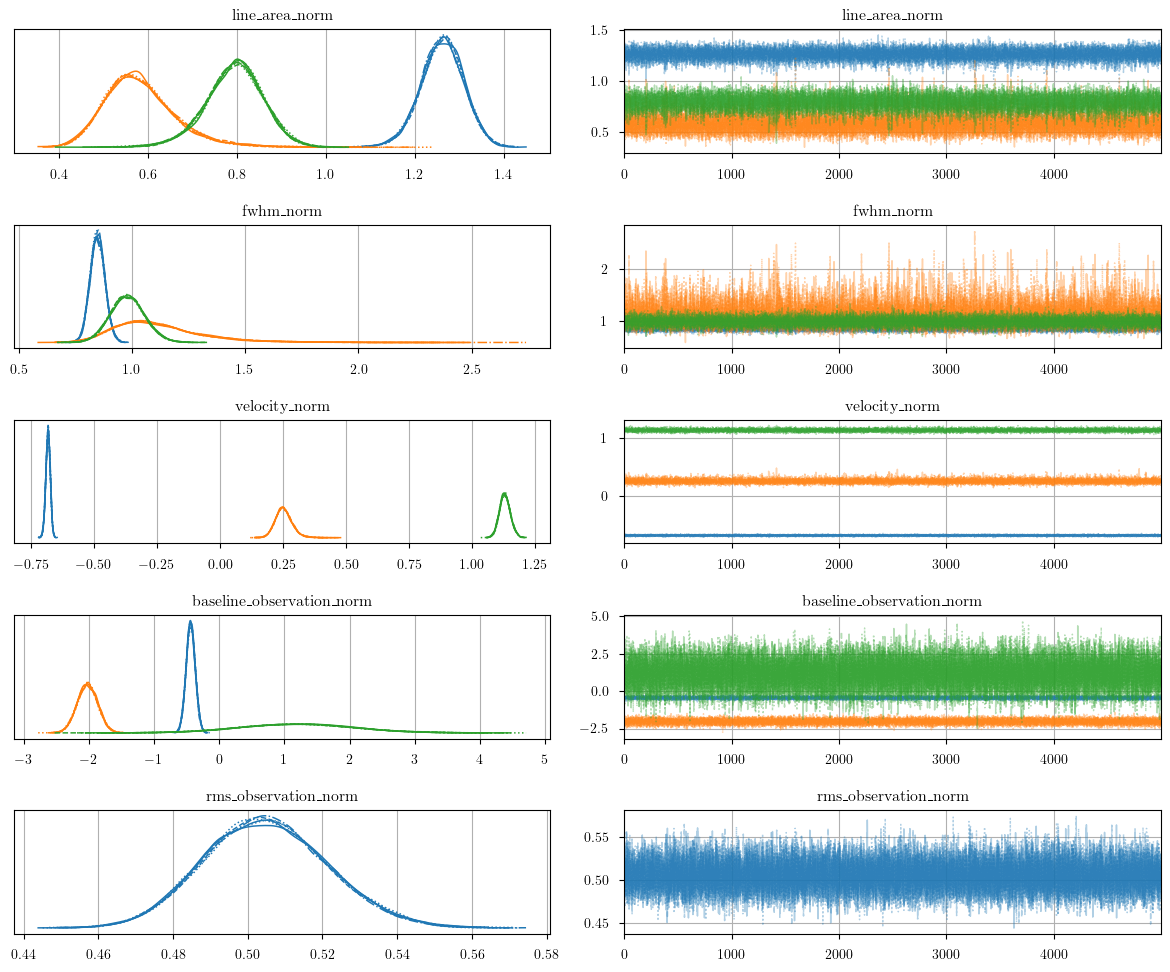

In [20]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [21]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.439   0.070   -0.568   -0.304      0.000   
baseline_observation_norm[1]   -2.025   0.156   -2.318   -1.736      0.001   
baseline_observation_norm[2]    1.189   0.869   -0.407    2.868      0.006   
velocity_norm[0]               -0.683   0.009   -0.700   -0.667      0.000   
velocity_norm[1]                0.253   0.033    0.192    0.316      0.000   
velocity_norm[2]                1.131   0.022    1.091    1.172      0.000   
line_area_norm[0]               1.261   0.049    1.170    1.352      0.000   
line_area_norm[1]               0.583   0.081    0.443    0.736      0.001   
line_area_norm[2]               0.794   0.065    0.674    0.919      0.001   
fwhm_norm[0]                    0.847   0.033    0.787    0.909      0.000   
fwhm_norm[1]                    1.117   0.204    0.786    1.497      0.002   
fwhm_norm[2]                    0.981   0.076    0.833    1.118      0.001   
rms_observation_norm            0.505   0.017    0.475    0.536      0.000   
line_area[0]                  252.139   9.733  233.968  270.405      0.084   
line_area[1]                  116.670  16.253   88.563  147.221      0.169   
line_area[2]                  158.803  13.028  134.718  183.767      0.126   
fwhm[0]                        25.420   0.979   23.609   27.277      0.008   
fwhm[1]                        33.508   6.120   23.581   44.897      0.067   
fwhm[2]                        29.415   2.271   25.005   33.553      0.021   
velocity[0]                   -34.159   0.439  -34.980  -33.331      0.003   
velocity[1]                    12.640   1.670    9.591   15.787      0.014   
velocity[2]                    56.539   1.076   54.565   58.616      0.010   
amplitude[0]                    9.323   0.288    8.765    9.852      0.001   
amplitude[1]                    3.304   0.295    2.758    3.867      0.002   
amplitude[2]                    5.077   0.280    4.570    5.613      0.002   
rms_observation                 1.010   0.033    0.950    1.073      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   19769.0   21241.0    1.0  
baseline_observation_norm[1]    0.001   28117.0   20376.0    1.0  
baseline_observation_norm[2]    0.005   22045.0   22437.0    1.0  
velocity_norm[0]                0.000   19248.0   19153.0    1.0  
velocity_norm[1]                0.000   16331.0   14794.0    1.0  
velocity_norm[2]                0.000   12380.0   14111.0    1.0  
line_area_norm[0]               0.000   13992.0   14365.0    1.0  
line_area_norm[1]               0.001   10151.0   10993.0    1.0  
line_area_norm[2]               0.001   11257.0   11237.0    1.0  
fwhm_norm[0]                    0.000   15403.0   18178.0    1.0  
fwhm_norm[1]                    0.003    9782.0   10033.0    1.0  
fwhm_norm[2]                    0.000   11964.0   14289.0    1.0  
rms_observation_norm            0.000   26441.0   20471.0    1.0  
line_area[0]                    0.068   13992.0   14365.0    1.0  
line_area[1]                    0.169   10151.0   10993.0    1.0  
line_area[2]                    0.107   11257.0   11237.0    1.0  
fwhm[0]                         0.006   15403.0   18178.0    1.0  
fwhm[1]                         0.077    9782.0   10033.0    1.0  
fwhm[2]                         0.014   11964.0   14289.0    1.0  
velocity[0]                     0.002   19248.0   19153.0    1.0  
velocity[1]                     0.014   16331.0   14794.0    1.0  
velocity[2]                     0.006   12380.0   14111.0    1.0  
amplitude[0]                    0.002   39171.0   21862.0    1.0  
amplitude[1]                    0.002   21042.0   19773.0    1.0  
amplitude[2]                    0.002   31435.0   18735.0    1.0  
rms_observation                 0.000   26441.0   20471.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [22]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

Running window adaptation


Output()

Adding log-likelihood to trace


In [23]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 0 2]
Chain 4 order: [2 1 0]
Chain 5 order: [0 2 1]
Adopting (first) most common order: [0 2 1]


Sampling: [observation]


Output()

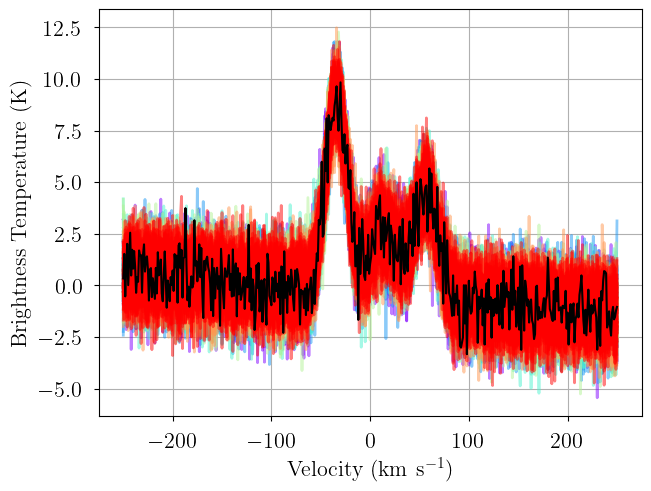

In [24]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

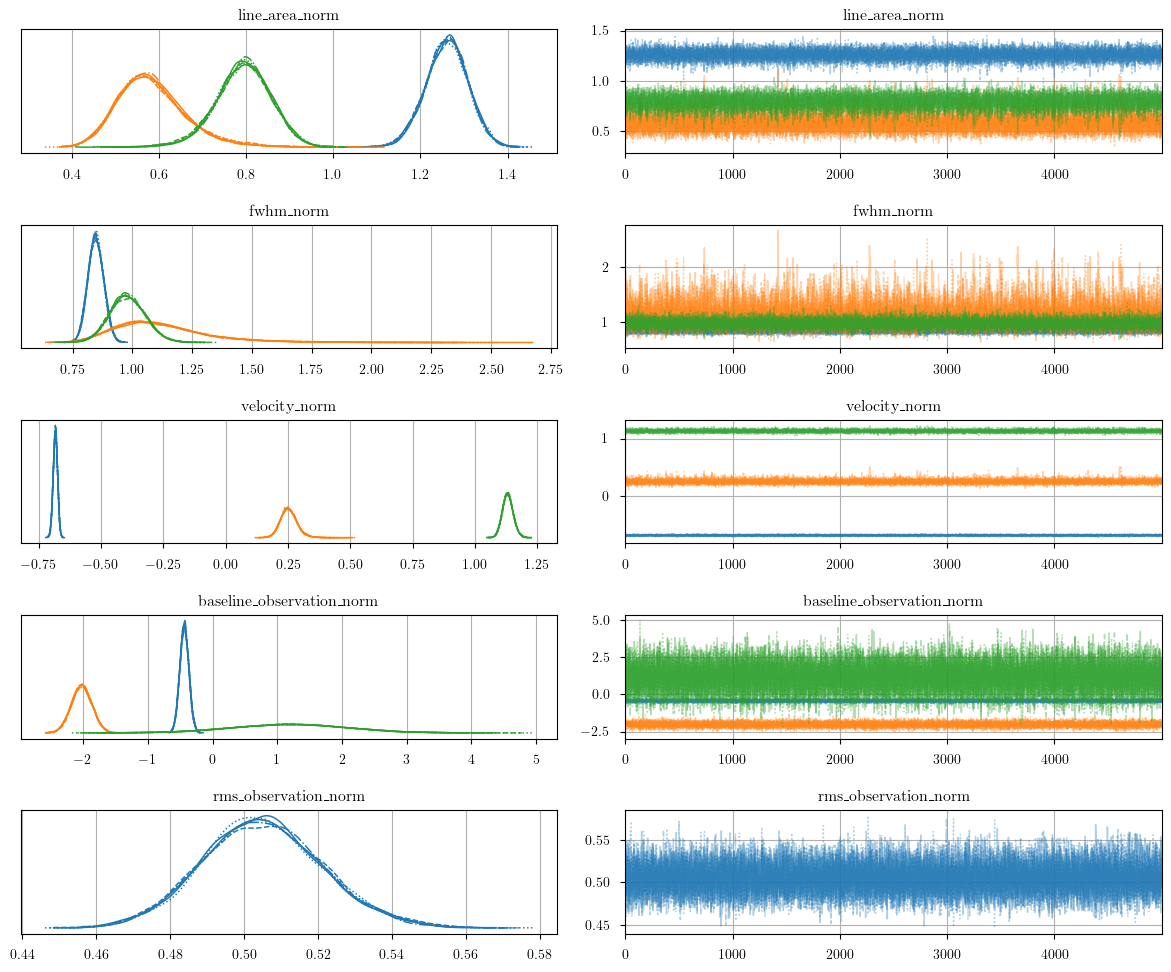

In [25]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [26]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.438   0.070   -0.570   -0.306      0.000   
baseline_observation_norm[1]   -2.025   0.156   -2.313   -1.727      0.001   
baseline_observation_norm[2]    1.187   0.879   -0.535    2.754      0.006   
velocity_norm[0]               -0.683   0.009   -0.700   -0.667      0.000   
velocity_norm[1]                0.253   0.034    0.192    0.317      0.000   
velocity_norm[2]                1.131   0.021    1.090    1.171      0.000   
line_area_norm[0]               1.260   0.049    1.166    1.348      0.000   
line_area_norm[1]               0.585   0.081    0.436    0.731      0.001   
line_area_norm[2]               0.793   0.065    0.670    0.912      0.001   
fwhm_norm[0]                    0.847   0.033    0.785    0.908      0.000   
fwhm_norm[1]                    1.122   0.205    0.781    1.494      0.002   
fwhm_norm[2]                    0.980   0.075    0.836    1.119      0.001   
rms_observation_norm            0.505   0.016    0.476    0.537      0.000   
line_area[0]                  252.015   9.739  233.123  269.595      0.083   
line_area[1]                  117.074  16.259   87.250  146.172      0.173   
line_area[2]                  158.621  12.965  134.064  182.414      0.130   
fwhm[0]                        25.400   0.981   23.565   27.234      0.008   
fwhm[1]                        33.668   6.145   23.428   44.829      0.068   
fwhm[2]                        29.389   2.260   25.090   33.559      0.020   
velocity[0]                   -34.170   0.438  -34.981  -33.338      0.003   
velocity[1]                    12.652   1.700    9.580   15.871      0.014   
velocity[2]                    56.557   1.070   54.524   58.556      0.009   
amplitude[0]                    9.325   0.286    8.786    9.859      0.001   
amplitude[1]                    3.299   0.293    2.728    3.832      0.002   
amplitude[2]                    5.076   0.283    4.553    5.608      0.002   
rms_observation                 1.010   0.033    0.951    1.075      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   19431.0   21016.0    1.0  
baseline_observation_norm[1]    0.001   26610.0   22286.0    1.0  
baseline_observation_norm[2]    0.005   21058.0   21672.0    1.0  
velocity_norm[0]                0.000   19225.0   19349.0    1.0  
velocity_norm[1]                0.000   17131.0   13647.0    1.0  
velocity_norm[2]                0.000   12979.0   14056.0    1.0  
line_area_norm[0]               0.000   13993.0   15127.0    1.0  
line_area_norm[1]               0.001    9975.0   10211.0    1.0  
line_area_norm[2]               0.001   10778.0   10217.0    1.0  
fwhm_norm[0]                    0.000   15920.0   18707.0    1.0  
fwhm_norm[1]                    0.003    9733.0    9657.0    1.0  
fwhm_norm[2]                    0.000   12591.0   15072.0    1.0  
rms_observation_norm            0.000   25937.0   20145.0    1.0  
line_area[0]                    0.064   13993.0   15127.0    1.0  
line_area[1]                    0.184    9975.0   10211.0    1.0  
line_area[2]                    0.125   10778.0   10217.0    1.0  
fwhm[0]                         0.005   15920.0   18707.0    1.0  
fwhm[1]                         0.083    9733.0    9657.0    1.0  
fwhm[2]                         0.014   12591.0   15072.0    1.0  
velocity[0]                     0.002   19225.0   19349.0    1.0  
velocity[1]                     0.018   17131.0   13647.0    1.0  
velocity[2]                     0.007   12979.0   14056.0    1.0  
amplitude[0]                    0.002   41402.0   23718.0    1.0  
amplitude[1]                    0.002   19907.0   18897.0    1.0  
amplitude[2]                    0.002   27948.0   16945.0    1.0  
rms_observation                 0.000   25937.0   20145.0    1.0

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [27]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Output()

Adding log-likelihood to trace


In [28]:
model.solve()

No solution found!
0 of 8 chains appear converged.


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

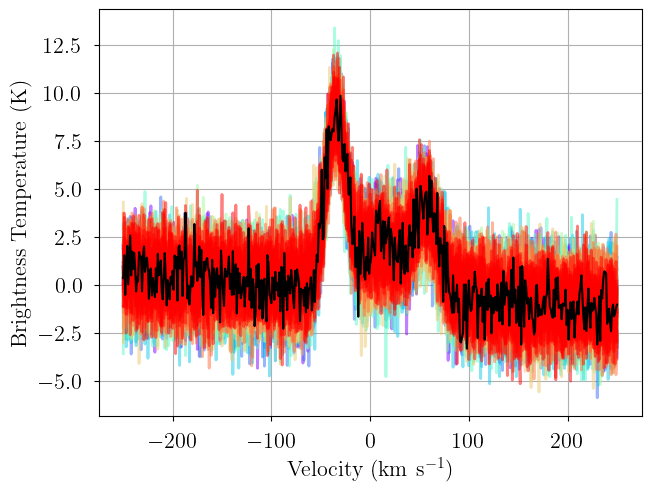

In [29]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

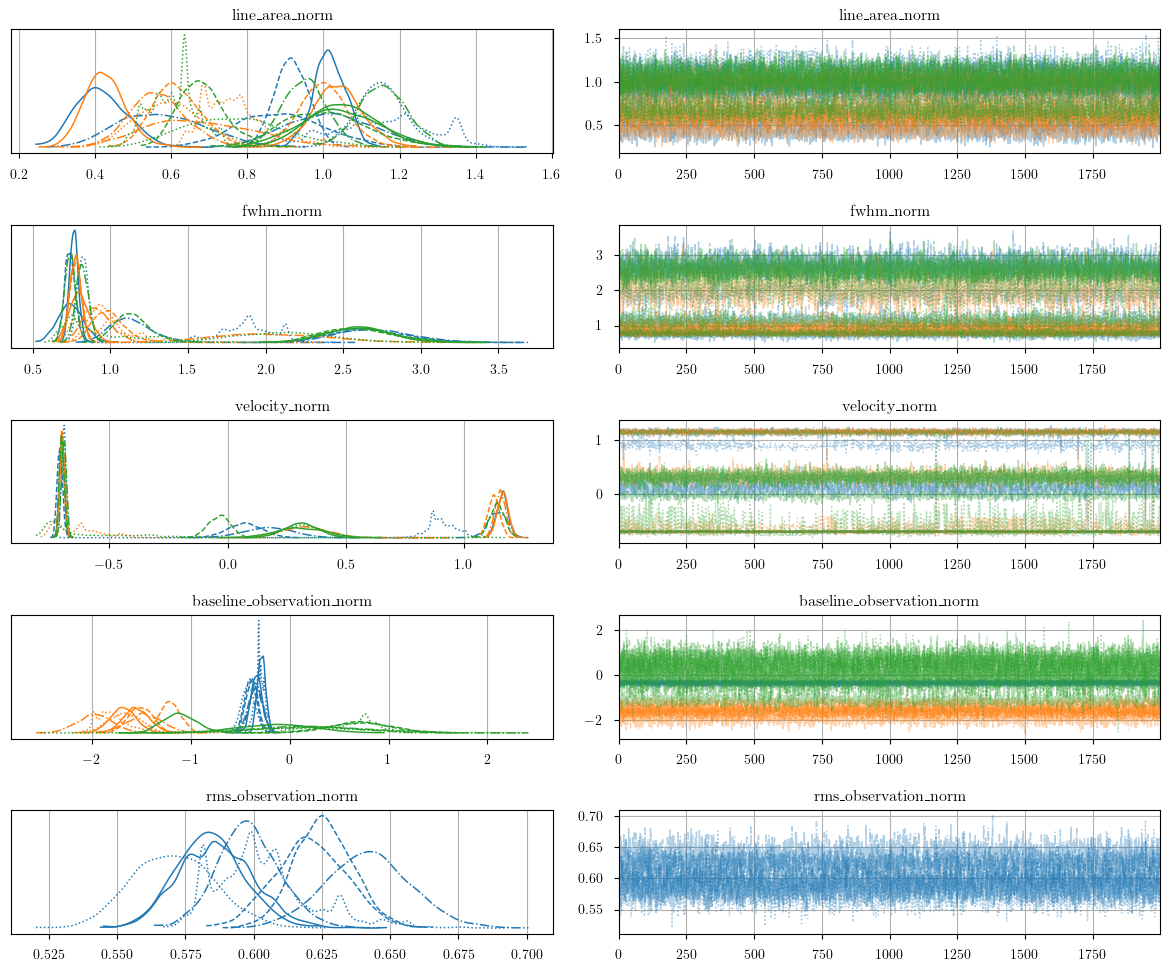

In [30]:
axes = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [31]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


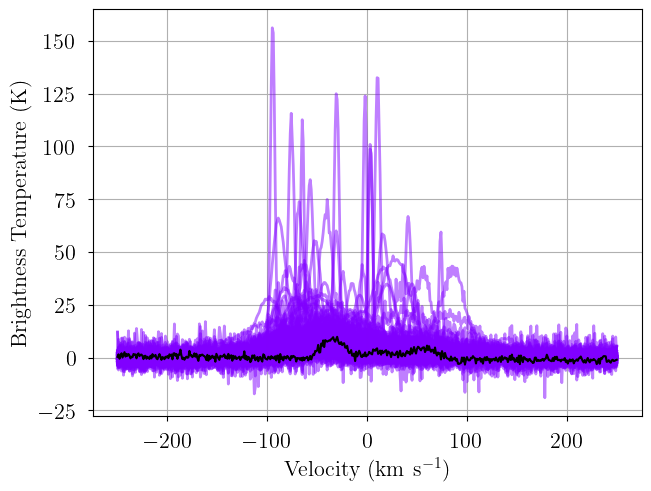

In [32]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [33]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Output()

Adding log-likelihood to trace


In [34]:
model.solve()

GMM converged to unique solution
6 of 8 chains appear converged.


Sampling: [observation]


Output()

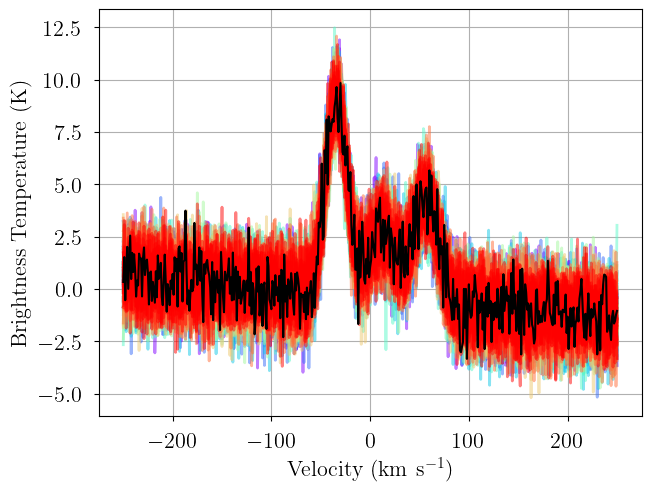

In [35]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

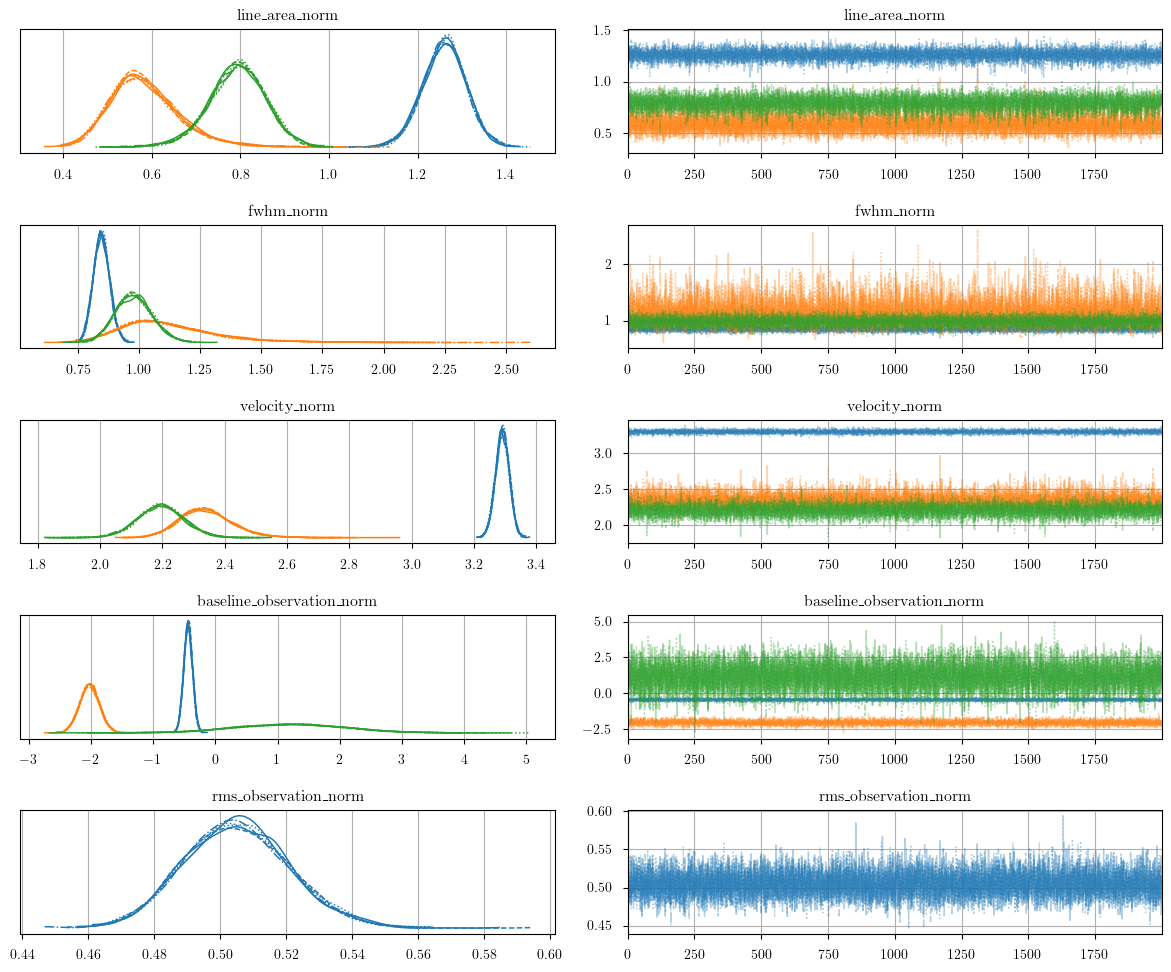

In [36]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [37]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.439   0.070   -0.574   -0.312      0.001   
baseline_observation_norm[1]   -2.026   0.157   -2.330   -1.741      0.001   
baseline_observation_norm[2]    1.194   0.876   -0.460    2.800      0.008   
line_area_norm[0]               1.260   0.049    1.167    1.350      0.000   
line_area_norm[1]               0.585   0.080    0.443    0.735      0.001   
line_area_norm[2]               0.793   0.064    0.672    0.913      0.001   
fwhm_norm[0]                    0.847   0.033    0.784    0.907      0.000   
fwhm_norm[1]                    1.122   0.201    0.797    1.505      0.002   
fwhm_norm[2]                    0.979   0.074    0.843    1.121      0.001   
velocity_norm[0]                3.292   0.022    3.251    3.332      0.000   
velocity_norm[1]                2.341   0.086    2.186    2.506      0.001   
velocity_norm[2]                2.195   0.074    2.048    2.327      0.001   
rms_observation_norm            0.505   0.016    0.476    0.535      0.000   
line_area[0]                  252.040   9.768  233.400  270.024      0.089   
line_area[1]                  116.944  16.004   88.675  147.037      0.146   
line_area[2]                  158.514  12.818  134.314  182.592      0.117   
fwhm[0]                        25.401   0.983   23.507   27.200      0.009   
fwhm[1]                        33.645   6.019   23.909   45.135      0.055   
fwhm[2]                        29.368   2.233   25.297   33.628      0.020   
velocity[0]                   -34.170   0.436  -34.976  -33.352      0.004   
velocity[1]                    12.659   1.672    9.667   15.872      0.015   
velocity[2]                    56.559   1.074   54.577   58.656      0.010   
amplitude[0]                    9.326   0.285    8.783    9.842      0.003   
amplitude[1]                    3.297   0.290    2.757    3.849      0.003   
amplitude[2]                    5.076   0.279    4.555    5.600      0.003   
rms_observation                 1.010   0.032    0.951    1.071      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   11457.0   11516.0    1.0  
baseline_observation_norm[1]    0.001   12108.0   11890.0    1.0  
baseline_observation_norm[2]    0.006   11403.0   11985.0    1.0  
line_area_norm[0]               0.000   12115.0   11970.0    1.0  
line_area_norm[1]               0.001   12076.0   11523.0    1.0  
line_area_norm[2]               0.000   11979.0   11815.0    1.0  
fwhm_norm[0]                    0.000   11839.0   11774.0    1.0  
fwhm_norm[1]                    0.002   12146.0   10565.0    1.0  
fwhm_norm[2]                    0.000   12095.0   11850.0    1.0  
velocity_norm[0]                0.000   12263.0   11860.0    1.0  
velocity_norm[1]                0.001   11944.0   11783.0    1.0  
velocity_norm[2]                0.001   11946.0   11412.0    1.0  
rms_observation_norm            0.000   12092.0   11000.0    1.0  
line_area[0]                    0.068   12115.0   11970.0    1.0  
line_area[1]                    0.140   12076.0   11523.0    1.0  
line_area[2]                    0.094   11979.0   11815.0    1.0  
fwhm[0]                         0.006   11839.0   11774.0    1.0  
fwhm[1]                         0.060   12146.0   10565.0    1.0  
fwhm[2]                         0.015   12095.0   11850.0    1.0  
velocity[0]                     0.003   12263.0   11860.0    1.0  
velocity[1]                     0.014   12012.0   11934.0    1.0  
velocity[2]                     0.007   11469.0   11446.0    1.0  
amplitude[0]                    0.002   11710.0   11613.0    1.0  
amplitude[1]                    0.002   11826.0   11505.0    1.0  
amplitude[2]                    0.002   11687.0   11380.0    1.0  
rms_observation                 0.000   12092.0   11000.0    1.0